<a href="https://colab.research.google.com/github/HussainBadreddeen/AutoML_Thesis/blob/main/hard_dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing libraries needed and importing the dataset from google drive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
# from google.colab import drive
# drive.mount('/content/drive')


file_path = "/content/drive/MyDrive/thesisdata/balanced-reviews.txt"

# Load as a DataFrame (change delimiter if needed)
df = pd.read_csv(file_path, sep="\t", encoding="utf-16")




## I follow the CRISP-DM process here.
I've already done business understanding since I've mentioned the goal and objectives of this project is to compare AutoML for arabic sentiment analysis with manual tuning of hyperparameters

## **Data Understanding**

In [ ]:
#first few rows
print(df.head())
print("----------------------------")
print()
#Number of Rows and coloumns
print('Number of rows and columns in the data set:', df.shape)
print("----------------------------")
print()
#Data types of the dataset
df.info()
print("----------------------------")
print()

# Display summary statistics for numerical features
print(df.describe())
print("----------------------------")
print()
#quick check if there are any missing values
print("Missing Values:")
print(df.isnull().sum())
print("----------------------------")
print()

   no Hotel name  rating    user type                   room type  \
0   2    فندق 72       2  مسافر منفرد  غرفة ديلوكس مزدوجة أو توأم   
1   3    فندق 72       5          زوج  غرفة ديلوكس مزدوجة أو توأم   
2  16    فندق 72       5          زوج                           -   
3  20    فندق 72       1          زوج          غرفة قياسية مزدوجة   
4  23    فندق 72       4          زوج  غرفة ديلوكس مزدوجة أو توأم   

            nights                                             review  
0  أقمت ليلة واحدة                  “ممتاز”. النظافة والطاقم متعاون.   
1  أقمت ليلة واحدة  استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...  
2      أقمت ليلتين  استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...  
3  أقمت ليلة واحدة  “استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...  
4      أقمت ليلتين  جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...  
----------------------------

Number of rows and columns in the data set: (105698, 7)
----------------------------

<class 'pandas.core.frame.DataFrame'>

##since we know that we are trying to measure sentiment we focus on data related to reviews and their ratings

Amount of Values in the column: 105698
----------------------------
Number of unique ratings: 4
The unique values are:  [2 5 1 4]
----------------------------
Count of 'rating one': 14382                    Percentage of Total= 13.606690760468505 %
----------------------------
Count of 'rating two': 38467                    Percentage of Total= 36.3933092395315 %
----------------------------
Count of 'rating four': 26450                    Percentage of Total= 25.024125338227783 %
----------------------------
Count of 'rating five': 26399                    Percentage of Total= 24.975874661772217 %
----------------------------


<Axes: xlabel='rating', ylabel='count'>

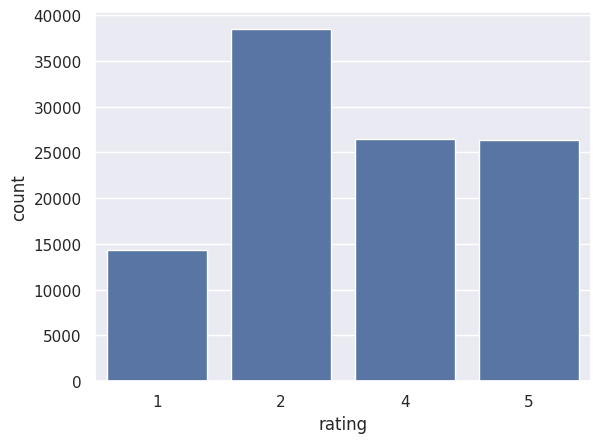

In [ ]:
#Checking How many values are Unqiue from the total values for the Column rating
print("Amount of Values in the column:", df["rating"].count())
print("----------------------------")
unique_ratings = df['rating'].nunique()
print(f"Number of unique ratings: {unique_ratings}")
print("The unique values are: " ,df['rating'].unique())
#1,2,4,5 are the unique values as they represent either negative (1,2) or positive (4,5). 3 was removed in the balanced version of the dataset
print("----------------------------")

count_of_rating_1 = (df['rating'] == 1).sum()
print("Count of 'rating one':", count_of_rating_1, "                   Percentage of Total=", count_of_rating_1/df["rating"].count()*100,"%")
print("----------------------------")

count_of_rating_2 = (df['rating'] == 2).sum()
print("Count of 'rating two':", count_of_rating_2, "                   Percentage of Total=", count_of_rating_2/df["rating"].count()*100,"%")
print("----------------------------")

count_of_rating_4 = (df['rating'] == 4).sum()
print("Count of 'rating four':", count_of_rating_4, "                   Percentage of Total=", count_of_rating_4/df["rating"].count()*100,"%")
print("----------------------------")

count_of_rating_5 = (df['rating'] == 5).sum()
print("Count of 'rating five':", count_of_rating_5, "                   Percentage of Total=", count_of_rating_5/df["rating"].count()*100,"%")
print("----------------------------")

#We can plot the number of ratings for each in a small graph here
sns.countplot(x = 'rating', data = df)
#(1-2)= negative
#(4-5)= positive

## We group ratings (1-2) and (4,5) to show total count of negative and positive sentiment respectively

Count of 'negative sentiment': 52849                    Percentage of Total= 50.0 %
Count of 'positive sentiment': 52849                    Percentage of Total= 50.0 %


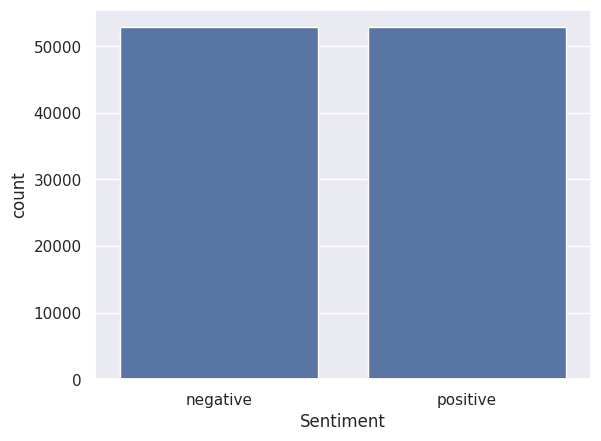

In [ ]:
#we create a new data frame called sentiment to have only positive and negative classes so we can compare safely without skewing the original data set
df['Sentiment'] = df['rating'].apply(lambda rating : 'negative' if rating < 4 else 'positive')

#we then plot the total count of each sentiment
sns.countplot(x = 'Sentiment', data = df)

negative_sentiment = (df['Sentiment'] == 'negative').sum()
print("Count of 'negative sentiment':", negative_sentiment, "                   Percentage of Total=", negative_sentiment/df["Sentiment"].count()*100,"%")

positive_sentiment = (df['Sentiment'] == 'positive').sum()
print("Count of 'positive sentiment':", positive_sentiment, "                   Percentage of Total=", positive_sentiment/df["Sentiment"].count()*100,"%")

#Data set appears to be prefectly balanced

##since we've covered the ratings we move on to the reviews

count                     105698
unique                    104036
top       استثنائي. كل شي. لا شي
freq                          62
Name: review, dtype: object

Sample Reviews:
 103942    مخيب للأمل. . الخدمه بطيئه جدا والوافي غير جيد...
92803     مخيب للأمل. الفطور والمكان. الخدمه والنظافه وا...
53413     “ضعيف المستوى”. الممرات جداً حارة لا يوجد فيها...
49789     جيد. الفندق جدا رائع. الطابق الاول رائحة اكل ا...
63650     جيد جداً. . المدخل المخصص للعرسان(موقف في القب...
Name: review, dtype: object


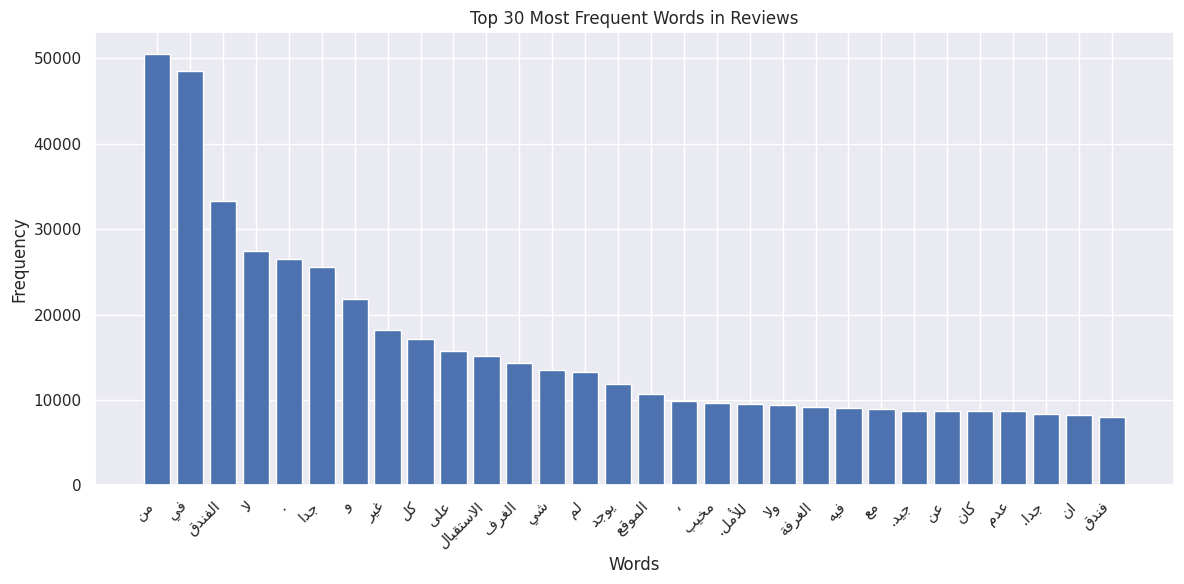

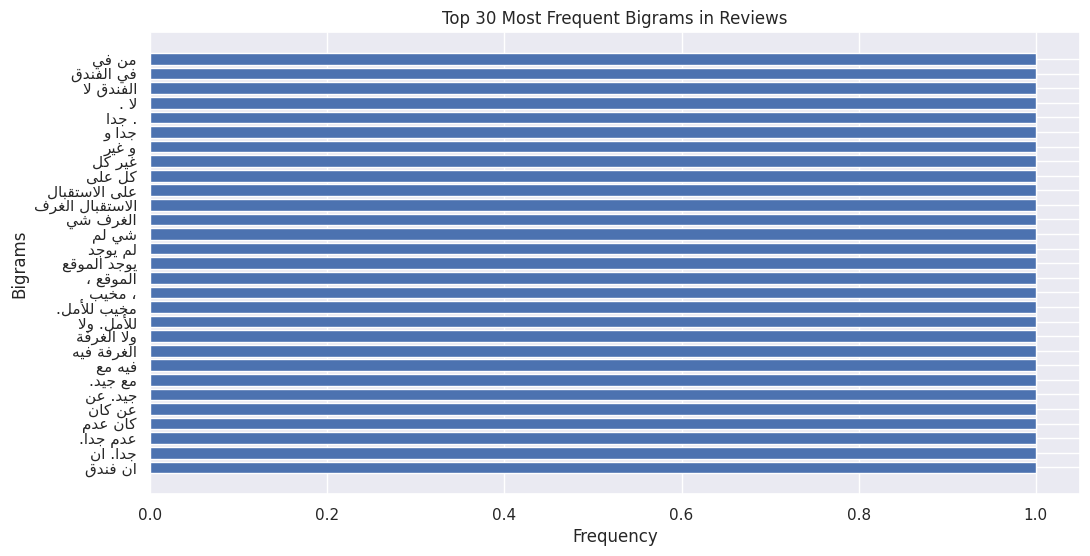

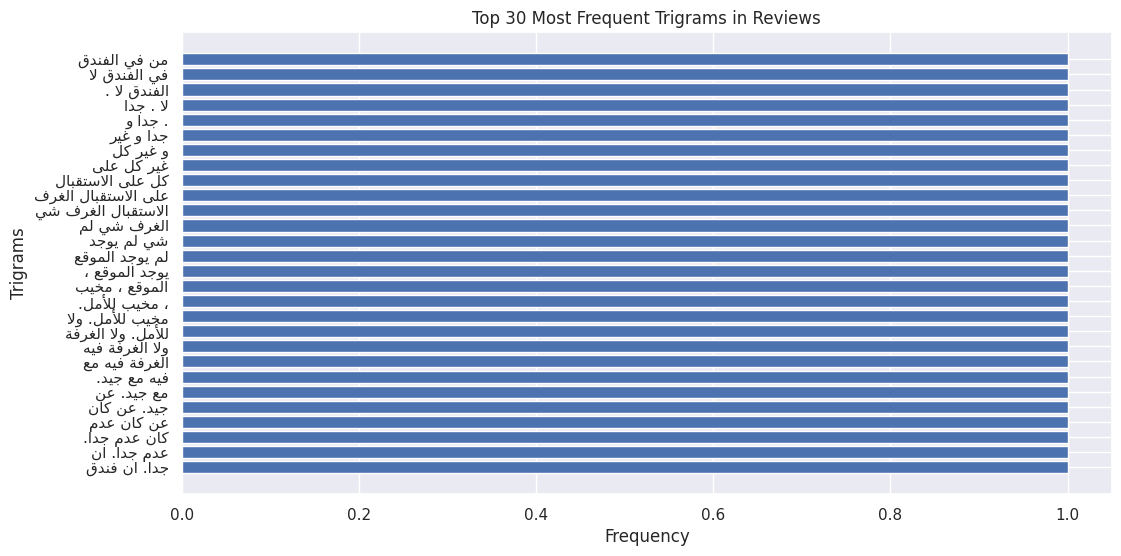

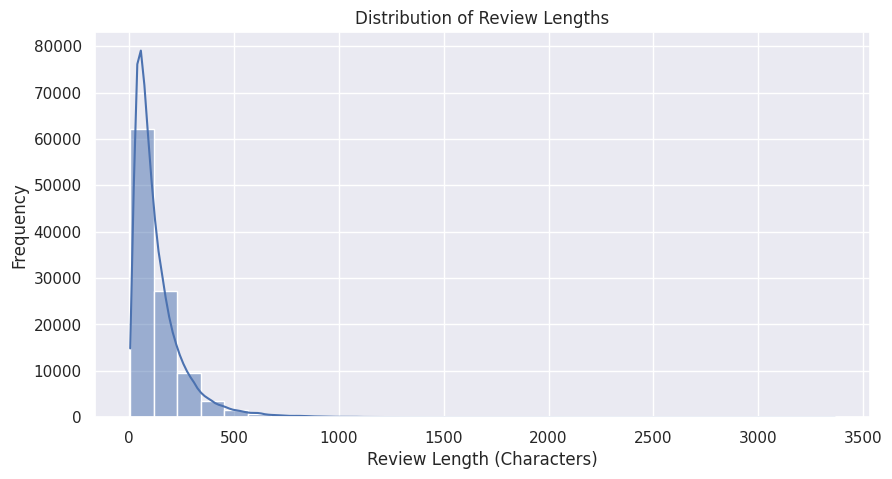

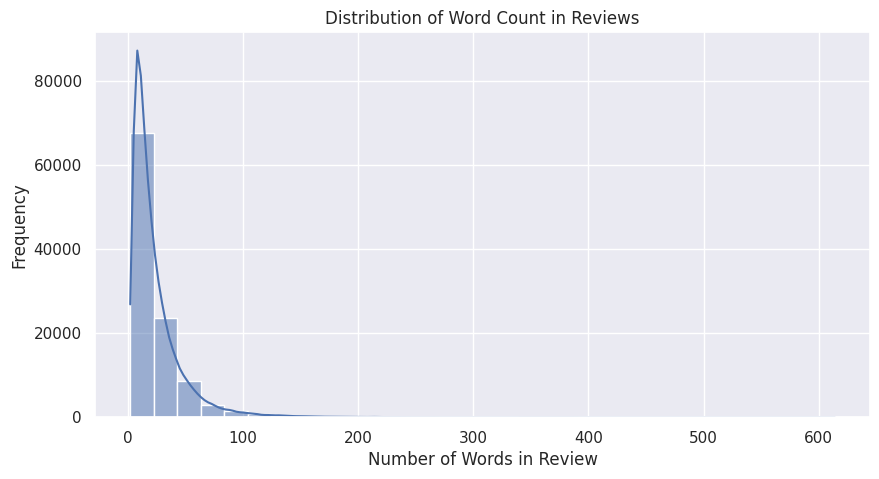

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


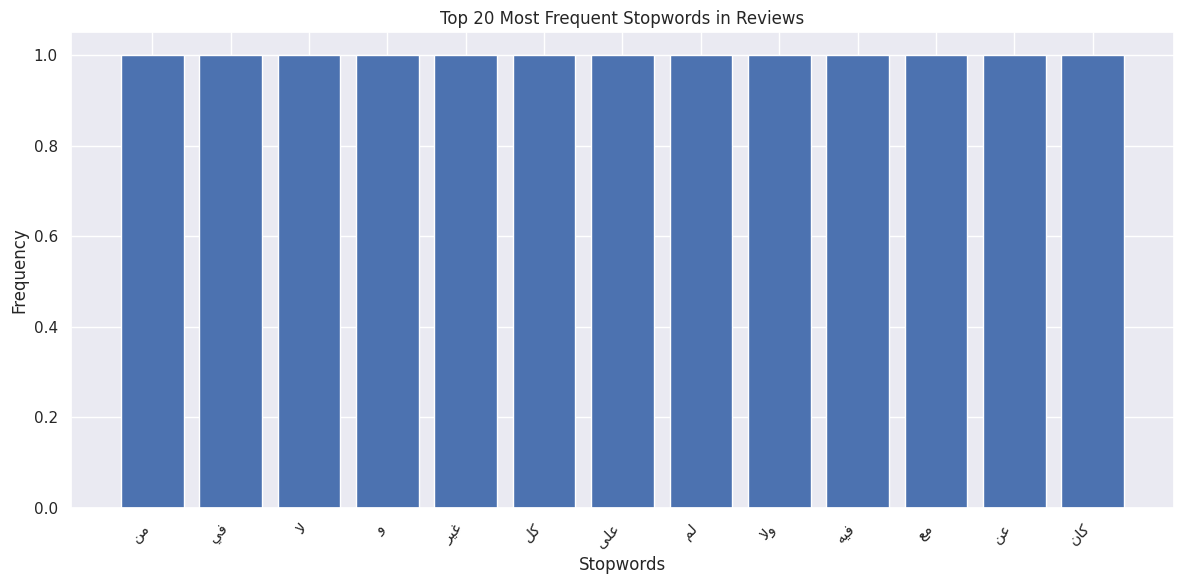

In [ ]:
# !pip install arabic-reshaper
# !pip install python-bidi
# !pip install camel-tools

#THIS CELL'S CODE WAS GENERATED USING A.I

from collections import Counter
from arabic_reshaper import reshape
from bidi.algorithm import get_display

# Inspect the review column
print(df['review'].describe())  # Basic statistics (count, unique, top, freq)
print("\nSample Reviews:\n", df['review'].sample(5))  # Print random 5 reviews

# Combine all reviews into a single string
all_reviews = ' '.join(df['review'].astype(str))

# Tokenization (splitting into words)
words = all_reviews.split()

# Count word frequencies
word_counts = Counter(words)

# Get the top 30 most frequent words
top_30_words = word_counts.most_common(30)

# Prepare Arabic words for visualization
words, counts = zip(*top_30_words)
reshaped_words = [reshape(word) for word in words]
display_words = [get_display(word) for word in reshaped_words]

# Plot word frequencies
plt.figure(figsize=(12, 6))
plt.bar(display_words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 30 Most Frequent Words in Reviews")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


from itertools import islice
from collections import Counter

# Function to generate n-grams
def get_ngrams(words, n):
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

# Generate bigrams and trigrams
bigrams = get_ngrams(words, 2)
trigrams = get_ngrams(words, 3)

# Count frequencies
bigram_counts = Counter(bigrams).most_common(30)
trigram_counts = Counter(trigrams).most_common(30)

# Prepare for visualization (Arabic reshaping)
bigram_words, bigram_freqs = zip(*bigram_counts)
trigram_words, trigram_freqs = zip(*trigram_counts)

bigram_display = [get_display(reshape(w)) for w in bigram_words]
trigram_display = [get_display(reshape(w)) for w in trigram_words]

# Plot bigrams
plt.figure(figsize=(12, 6))
plt.barh(bigram_display, bigram_freqs)
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.title("Top 30 Most Frequent Bigrams in Reviews")
plt.gca().invert_yaxis()  # Invert for better readability
plt.show()

# Plot trigrams
plt.figure(figsize=(12, 6))
plt.barh(trigram_display, trigram_freqs)
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.title("Top 30 Most Frequent Trigrams in Reviews")
plt.gca().invert_yaxis()
plt.show()


import seaborn as sns

# Compute review lengths
df['review_length'] = df['review'].astype(str).apply(len)

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.xlabel("Review Length (Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()



# Compute review length in words and characters
df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))
df['char_count'] = df['review'].astype(str).apply(len)

# Plot word count distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.xlabel("Number of Words in Review")
plt.ylabel("Frequency")
plt.title("Distribution of Word Count in Reviews")
plt.show()



import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords



# Load Arabic stopwords
stopwords_list = set(stopwords.words('arabic'))

# Count how many words are stopwords
stopword_counts = Counter([word for word in words if word in stopwords_list])
top_20_stopwords = stopword_counts.most_common(30)

# Prepare stopwords for visualization
stopword_words, stopword_freqs = zip(*top_20_stopwords)
stopword_display = [get_display(reshape(w)) for w in stopword_words]

# Plot stopword frequencies
plt.figure(figsize=(12, 6))
plt.bar(stopword_display, stopword_freqs)
plt.xlabel("Stopwords")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Stopwords in Reviews")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

since we've inspected our main 2 attributes rating and review. we move on to data preperation where we drop other columns and start preprocessing the reviews

##**Data preperation**

In [ ]:
df_copy = df[['rating', 'review']].copy()

df_copy.head()

,rating,review
0,2,“ممتاز”. النظافة والطاقم متعاون.
1,5,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,5,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,1,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,4,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...
